<a href="https://colab.research.google.com/github/Lainey1225/tmo3/blob/main/ErrorModel/errorsXGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import minmax_scale  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.lines import Line2D


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
import os



In [ ]:
# Defining dataset and browsing content
data = pd.read_csv('https://raw.githubusercontent.com/tleitch/BDML/main/ErrorModel/errors.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   var 1    124 non-null    float64
 1   var 2    124 non-null    float64
 2   var 3    124 non-null    float64
 3   var 4    124 non-null    int64  
 4   var 5    124 non-null    int64  
 5   var 6    124 non-null    float64
 6   var 7    124 non-null    int64  
 7   var 8    124 non-null    float64
 8   var 9    124 non-null    float64
 9   Outcome  124 non-null    int64  
dtypes: float64(6), int64(4)
memory usage: 9.8 KB


In [ ]:
data.head()

,var 1,var 2,var 3,var 4,var 5,var 6,var 7,var 8,var 9,Outcome
0,0.653573,258.855037,22.999826,1,71,1.240224,2,21.472308,-0.405010,1
1,0.576011,270.889712,23.748059,1,76,1.175028,3,21.123431,0.611585,0
2,0.657729,281.479553,24.914027,2,81,1.177164,1,19.483365,1.054139,0
3,0.546925,302.548908,22.341946,2,76,1.187526,1,20.837815,0.253949,0
4,0.569086,258.731574,22.351487,1,72,1.296652,1,20.409844,0.903367,0


This data is pretty clean from the case authors. Looks like missing is taken care of, the data has been pre-balanced by some algorithm. Only thing we might want to do before using it is standardize/normalize. let's create an X and y for working with the data.

In [ ]:
X=data.iloc[0:,0:9]
X.tail()

,var 1,var 2,var 3,var 4,var 5,var 6,var 7,var 8,var 9
119,0.636953,299.510831,22.146210,2,81,1.242409,2,21.448554,-0.382400
120,0.627258,259.353564,23.078033,1,83,1.239721,1,19.630472,-0.164600
121,0.544155,299.066928,25.308636,2,82,1.224124,1,21.104548,1.548561
122,0.643878,275.315415,23.123910,1,79,1.226226,3,20.911596,-0.734790
123,0.603712,277.675805,22.363775,2,73,1.187769,3,20.601871,0.061978


In [ ]:
y=data["Outcome"]
y.head()

0    1
1    0
2    0
3    0
4    0
Name: Outcome, dtype: int64

Var 4, var 5, and var 7 all look like they might be categorical factors, let's check

In [ ]:
X["var 4"].unique()

array([1, 2])

In [ ]:
X["var 5"].unique()

array([71, 76, 81, 72, 88, 80, 85, 82, 70, 78, 90, 79, 77, 73, 83, 86, 89,
       84, 87, 74, 75])

In [ ]:
X["var 7"].unique()

array([2, 3, 1])

Yep, these 3 variables will need 1 hot encoding

In [ ]:
data=X.copy()
data = pd.get_dummies(data,prefix=['var 4'], columns = ['var 4'])
data = pd.get_dummies(data,prefix=['var 5'], columns = ['var 5'])
data = pd.get_dummies(data,prefix=['var 7'], columns = ['var 7'])
Xencd=data
Xencd.head()


,var 1,var 2,var 3,var 6,var 8,var 9,var 4_1,var 4_2,var 5_70,var 5_71,var 5_72,var 5_73,var 5_74,var 5_75,var 5_76,var 5_77,var 5_78,var 5_79,var 5_80,var 5_81,var 5_82,var 5_83,var 5_84,var 5_85,var 5_86,var 5_87,var 5_88,var 5_89,var 5_90,var 7_1,var 7_2,var 7_3
0,0.653573,258.855037,22.999826,1.240224,21.472308,-0.405010,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.576011,270.889712,23.748059,1.175028,21.123431,0.611585,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.657729,281.479553,24.914027,1.177164,19.483365,1.054139,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0.546925,302.548908,22.341946,1.187526,20.837815,0.253949,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.569086,258.731574,22.351487,1.296652,20.409844,0.903367,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Let's create train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xencd, y, test_size=0.25, random_state=42)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (93, 32)
y_train (93,)
X_test (31, 32)
y_test (31,)


In [ ]:
# Functions

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    

In [ ]:
# Create RF classification model with GridSearchCV
# n_estimators: The number of trees in the forest.
# criterion, min_samples_split and min_samples_leaf are same to decision tree parameters.
rf_grid = {"n_estimators": [50, 100], "criterion": ["gini", "entropy"],
           "min_samples_split":[3,4,5,6,7], "min_samples_leaf":[1,2,3,4,5,6]}
rforest = GridSearchCV(RandomForestClassifier(random_state=42), rf_grid, cv=5, iid=False)
rforest.fit(X_train, y_train)

print("RF Tuned Hyperparameters", rforest.best_params_)
print("RF Tuned Best Score:", round(rforest.best_score_,3))

RF Tuned Hyperparameters {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
RF Tuned Best Score: 0.839


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [ ]:
best_clf_rforest = rforest.best_estimator_
best_clf_rforest.fit(X_train, y_train)
rforest_y_head = best_clf_rforest.predict(X_test)
print("Random Forest (RF) Classification Accuracy: {}%" .format(round(best_clf_rforest.score(X_test, y_test)*100,2)))

Random Forest (RF) Classification Accuracy: 93.55%


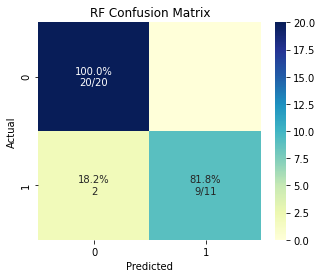

In [ ]:
plot_cm(y_test, rforest_y_head, title="RF Confusion Matrix")

To get you started on the HW contest, here is an xgboost model implemented w/o tuning.

In [ ]:
from xgboost import XGBClassifier
xgbModel=XGBClassifier()
xgbModel.fit(X_train, y_train)
xgbModel_y_head = xgbModel.predict(X_test)
print("XGB  Classification Accuracy: {}%" .format(round(xgbModel.score(X_test, y_test)*100,2)))

XGB  Classification Accuracy: 74.19%


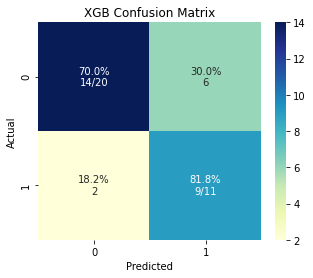

In [ ]:
plot_cm(y_test, xgbModel_y_head, title="XGB Confusion Matrix")